In [18]:
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model.keras'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [2]:
! pip install tensorflow

In [19]:
import tensorflow as tf

from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

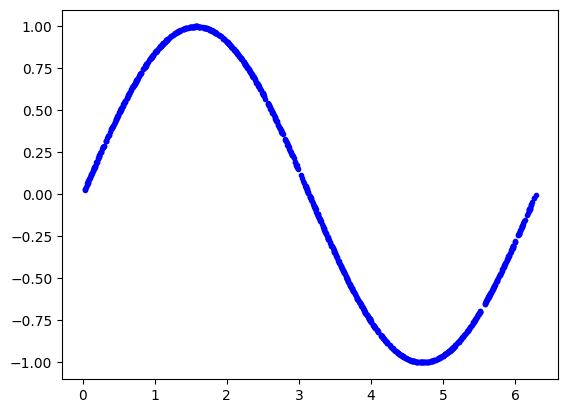

In [20]:
SAMPLES = 1000

x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

np.random.shuffle(x_values)

y_values = np.sin(x_values).astype(np.float32)

plt.plot(x_values, y_values, 'b.')
plt.show()

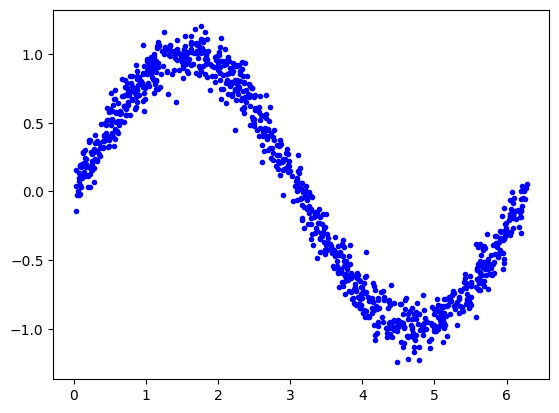

In [21]:

y_values += 0.1 * np.random.randn(*y_values.shape)


plt.plot(x_values, y_values, 'b.')
plt.show()

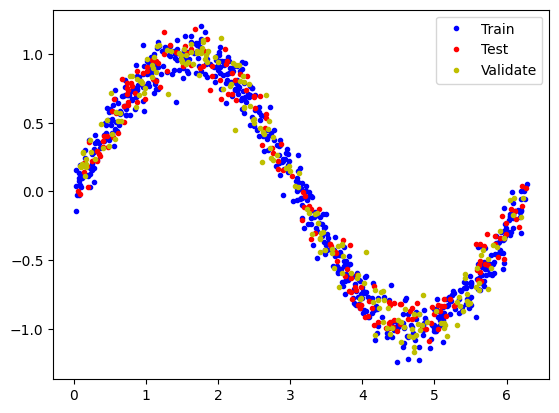

In [22]:
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


In [24]:
model = tf.keras.Sequential([
    keras.layers.Input(shape=(1,)),

    keras.layers.Dense(8, activation='relu'),


    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [25]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 10.1756 - mae: 2.4378 - val_loss: 9.4659 - val_mae: 2.3573
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1894 - mae: 2.3098 - val_loss: 8.5552 - val_mae: 2.2347
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2946 - mae: 2.1916 - val_loss: 7.7338 - val_mae: 2.1200
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4895 - mae: 2.0821 - val_loss: 6.9983 - val_mae: 2.0152
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7699 - mae: 1.9835 - val_loss: 6.3423 - val_mae: 1.9220
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1287 - mae: 1.8941 - val_loss: 5.7580 - val_mae: 1.8390
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5580 - mae: 1.8112 - val_loss: 5.2377 - val_mae: 1.7637
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0499 - mae: 1.7344 - val_loss: 4.7738 - val_mae: 1.6944
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss:

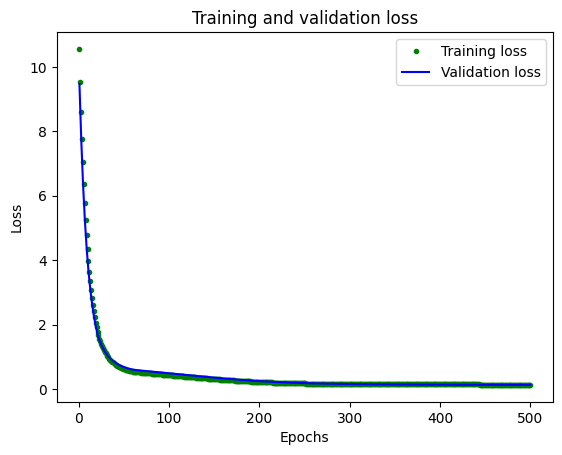

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

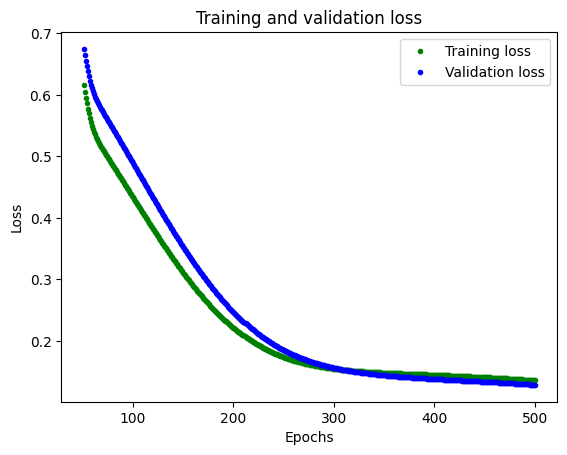

In [27]:
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

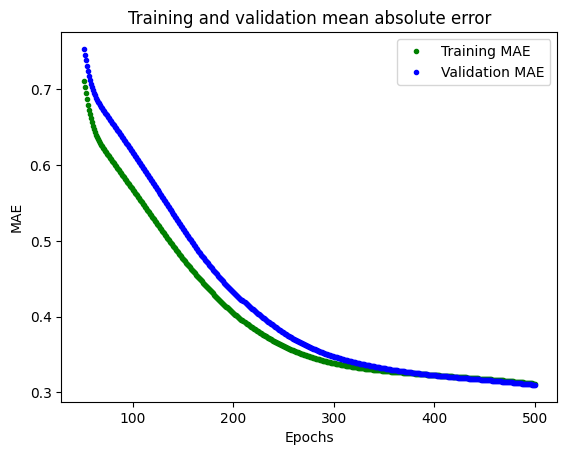

In [28]:
plt.clf()

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1482 - mae: 0.3358
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


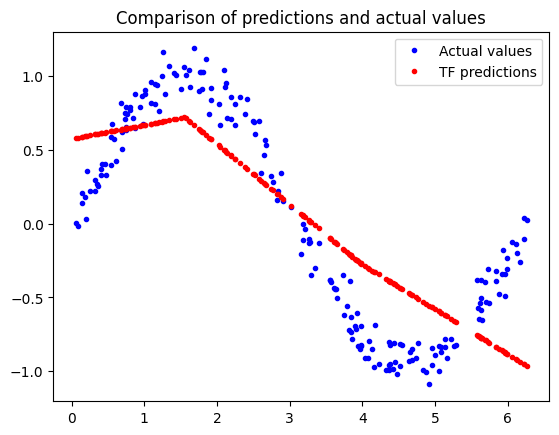

In [29]:
test_loss, test_mae = model.evaluate(x_test, y_test)

y_test_pred = model.predict(x_test)

plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

In [30]:
# Save the model to disk
model.save(MODEL_TF)
print(MODEL_TF)

models/model.keras


In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

open(MODEL_TFLITE, "wb").write(model_tflite)

Saved artifact at '/tmp/tmp8pgty0ue'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135876081730192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876081731152: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmpte5r71op'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135876081730192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304080: TensorS

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


2376

In [32]:
def predict_tflite(tflite_model, x_test):
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])

  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"]).item()

  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

In [33]:
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [34]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

open(MODEL_TFLITE, "wb").write(model_tflite)

Saved artifact at '/tmp/tmp6dw3juve'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135876081730192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876081731152: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmp2ayhxuv0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135876081730192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135876126304080: TensorS

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


2376

In [35]:

!apt-get update && apt-get -qq install xxd
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,222 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,491 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,870 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/uni